In [1]:
import sys
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
import random as rnd
from PIL import Image
from keras.utils import to_categorical

In [2]:
path = "tests/datasets/Images/Skin canser"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

tests/datasets/Images/Skin canser/benign
tests/datasets/Images/Skin canser/malignant


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                        

In [8]:
class Genome:
    def __init__(self,filter,fit):
        self.crop_dimension=filter
        self.fit=fit   

In [9]:
class FilterGeneticAlgorithm:
    
    def __init__(self, X_train=None, Y_train=None, X_test=None, Y_test=None, model=None, loss=None, IMAGE_SIZE=(224,224)):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.model=model
        self.loss=loss
        self.IMAGE_SIZE=IMAGE_SIZE
    
    
    def generate_Selection(self):
        width, height = self.IMAGE_SIZE
        left=rnd.randint(0, width-1)
        top=rnd.randint(0, height-1)
        right=left+rnd.randint(0, width-left)
        bottom=top+rnd.randint(0, height-top)
        return [(top,bottom),(left, right)]
    
    
    def generate_Population(self, size:int):
        width, height=self.IMAGE_SIZE
        population=[Genome([(0,height),(0,width)], self.fitness([(0,height),(0,width)]))]
        for _ in range(size-1):
            crop_dimension=self.generate_Selection() 
            population.append(Genome(crop_dimension,self.fitness(crop_dimension)))
        
        return population 
    
    
    
    def fitness(self, filter): 
        X_train=self.get_newData(self.X_train,filter)
        evaluations=0
    
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        print("--------------------------------------------------------------------------------")

        for train_index, test_index in kf.split(X_train):
            
            model= keras.models.clone_model(self.model)
            
            model.compile(optimizer="adam", loss=self.loss, metrics=['accuracy'])
            
            train_index, test_index = train_index.tolist(), test_index.tolist()
            x_train, x_test, y_train, y_test = np.array(X_train)[train_index], np.array(X_train)[test_index], np.array(self.Y_train)[train_index], np.array(self.Y_train)[test_index]
            
            model.fit(x_train, y_train, epochs=1)
            
            evaluations+=model.evaluate(x_test,y_test)[1]
            
            gc.collect()
        
        print(f"crop {filter} fit: {evaluations/10}")
        return evaluations/10
    
    
    
    def selection_pair(self, population:list[Genome]):
        return rnd.choices(
            population=population,
            weights=[genome.fit for genome in population],
            k=2
        )

    
    
    def single_point_crossover(self, a: Genome, b: Genome):
        c = rnd.choice([True, False])
        if not c:
            return a,b
                
        c1= Genome([a.crop_dimension[0],b.crop_dimension[1]], self.fitness([a.crop_dimension[0],b.crop_dimension[1]]))
        c2= Genome([b.crop_dimension[0],a.crop_dimension[1]], self.fitness([b.crop_dimension[0],a.crop_dimension[1]]))
            
        return  c1,c2
    
    
    
    def mutation(self, genome: Genome, probability: float=0.05):
        width, height = self.IMAGE_SIZE
        
        left=genome.crop_dimension[1][0]
        right=genome.crop_dimension[1][1]
        top=genome.crop_dimension[0][0]
        bottom=genome.crop_dimension[0][1]
        
        if rnd.random()< probability:
            left= rnd.randint(0, width-1)
            if left< right:
                if rnd.random()< probability:
                    right=rnd.randint(left+1, width)
            else:
                right=rnd.randint(left+1, width)
        
        
        if rnd.random()< probability:
            left= rnd.randint(0, height-1)
            if top< bottom:
                if rnd.random()< probability:
                    right=rnd.randint(top+1, height)
            else:
                right=rnd.randint(top+1, height)
        
        
        if [(top,bottom),(left, right)]==genome.crop_dimension:
            return genome
        return Genome([(top,bottom),(left, right)], self.fitness([(top,bottom),(left, right)]))
    
    
    def crop_Image(self, image, crop_dimension):
        left = crop_dimension[0][0]
        right = crop_dimension[0][1]
        top = crop_dimension[1][0]
        bottom = crop_dimension[1][1]

        pil_img = Image.fromarray(image)

        cropped_img = pil_img.crop((left, top, right, bottom))

        resized_img = cropped_img.resize((224, 224))

        resized_img_np = np.array(resized_img)

        return resized_img_np
    
    
    
    def get_newData(self, data, crop_dimension:list):
        return [ self.crop_Image(image,crop_dimension) for image in data]
    
    
    
    def run(self, generation_limit: int, population_size: int):

        population = self.generate_Population(population_size)

        for i in range(generation_limit):

            population = sorted(
                population,
                key=lambda genome: genome.fit,
                reverse=True
            )

            print('#################################################################################################################################################################') 
            print(f"\ngeneration: {i} best crop :{population[0].crop_dimension} fit: {population[0].fit}\n")
            print('#################################################################################################################################################################')

            next_generation = population[0:2]

            for j in range(int(len(population)/2)-1):
                parent = self.selection_pair(population)
                a, b = self.single_point_crossover(parent[0], parent[1])
                next_generation += [self.mutation(a), self.mutation(b)]

            population = next_generation

            
        population = sorted(
            population,
            key=lambda genome: genome.fit,
            reverse=True
        )

        return population[0]

In [10]:
ga=FilterGeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 15ms/step - loss: 1.3706 - accuracy: 0.6130
crop [(0, 224), (0, 224)] fit: 0.6398099064826965
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 16ms/step - loss: 2.4063 - accuracy: 0.5826
crop [(68, 90), (162, 169)] fit: 0.5981366515159607
[(0, 224), (0, 224)] 0.6398099064826965
[(0, 224), (0, 224)] 0.6398099064826965
[(68, 90), (162, 169)] 0.5981366515159607
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 15ms/step - loss: 1.4132 - accuracy: 0.6043
crop [(0, 224), (162, 169)] fit: 0.6081234753131867
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 16ms/step - loss: 3.1054 - accuracy: 0.5870
crop [(68, 90), (0, 224)] fit: 0.5890513777732849
[(0, 2

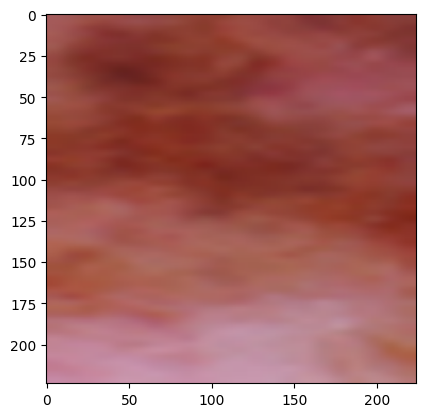

In [11]:
selection= ga.generate_Selection()
population= ga.generate_Population(2)
print(f"{population[0].crop_dimension} {population[0].fit}")
pairs= ga.selection_pair(population)
print(f"{pairs[0].crop_dimension} {pairs[0].fit}")
print(f"{pairs[1].crop_dimension} {pairs[1].fit}")
new_items= ga.single_point_crossover(pairs[0],pairs[1])
print(f"{new_items[0].crop_dimension} {new_items[0].fit}")
print(f"{new_items[1].crop_dimension} {new_items[1].fit}")
new= ga.mutation(new_items[1])
print(f"{new.crop_dimension} {new.fit}")
img= ga.crop_Image(X_train[0],new.crop_dimension)
plt.imshow(img)
plt.show()

In [12]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

new_model = keras.Sequential([
    layers.BatchNormalization(input_shape=(200, 200, 3))
])

for layer in model.layers[1:]:
    new_model.add(layer)

new_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 200, 200, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           multiple                  448       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                      